In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
if device=='cuda':
    torch.cuda.manual_seed_all(0)

In [5]:
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

In [7]:
# make dataset to input
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [10]:
seq_length = 7
data_dim = 5 # 시작, 최고, 최저, 종가, 등
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [11]:
# load data
xy = np.loadtxt("/content/data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [12]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x


net = Net(data_dim, hidden_dim, output_dim, 1)

In [13]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

In [14]:
# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

0 0.2271038144826889
1 0.18340934813022614
2 0.15106436610221863
3 0.1261231005191803
4 0.10598734021186829
5 0.08915016800165176
6 0.07493706047534943
7 0.06327900290489197
8 0.05449602007865906
9 0.04902385547757149
10 0.04693441092967987
11 0.04731706529855728
12 0.04838264361023903
13 0.04839477315545082
14 0.046337660402059555
15 0.04207770526409149
16 0.03620168939232826
17 0.029662000015378
18 0.023386556655168533
19 0.01801123283803463
20 0.013800657354295254
21 0.010714652016758919
22 0.008532216772437096
23 0.0069765071384608746
24 0.005824481602758169
25 0.004987423308193684
26 0.004524713382124901
27 0.0045546842738986015
28 0.005089899990707636
29 0.005920969881117344
30 0.006684894207865
31 0.0070726750418543816
32 0.006973991170525551
33 0.006471904460340738
34 0.005753519479185343
35 0.005014692898839712
36 0.004395292606204748
37 0.003953744191676378
38 0.0036766391713172197
39 0.0035109848249703646
40 0.0034013076219707727
41 0.0033151074312627316
42 0.003248894819989

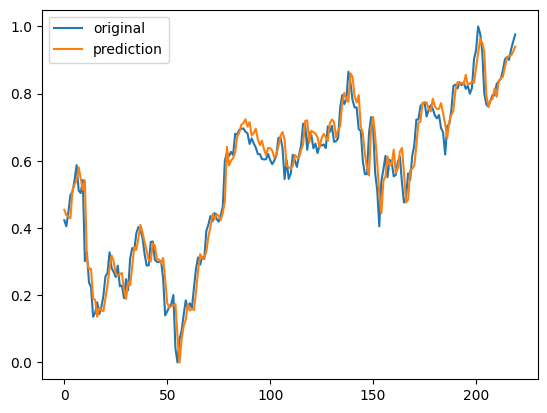

In [17]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()